# Load the data

In [15]:
import numpy as np
import pandas as pd #Pandas lib

data = pd.read_csv("book.csv") #loading the csv data file
data.head()

,sys,mod,con_id,g_int_typ,g_ag_id,g_swn,g_bus_unit,gen_bus_uni_skill,gen_skill,last_session_flag,lump_sum_typ_service_Code,payment_reason_type,payment_amount,recommending_user_code,Legal_Name
0,Gen&Vet,01-Jan-20,b303153,inbound,pge001,abc134,WorkandIncome,WI_Appointments,WI_Gen_Advances,1,"Hotels, Motels, Resorts",70,$330.00,HYAT,TWC
1,Gen&Vet,05-Feb-20,b303154,outbound,avc003,abc135,WorkandIncome,WI_Appointments,WI_Appointments,1,"Eating Places, Restaurants",856,"$1,300.00",GEHU,BL
2,Gen,01-Sep-20,b303155,inbound,hgh005,abc136,WorkandIncome,WI_Appointments,WI_Appointments,1,Quick Payment Service-Fast-Food Restaurants,93,"$1,400.00",OKAT,TPD
3,Gen&Vet,01-Jul-20,b303156,outbound,kji005,abc137,WorkandIncome,WI_Appointments,WI_Appointments,1,Taxi Services,72,"$1,400.00",GEHU,PKS
4,Gen,01-Jul-20,b303157,inbound,liy324,abc138,WorkandIncome,WI_Appointments,WI_Appointments,1,"Hotels, Motels, Resorts",65,"$1,100.00",LKUY,PKS


In [16]:
data.columns

Index(['sys', 'mod', 'con_id', 'g_int_typ', 'g_ag_id', 'g_swn', 'g_bus_unit',
       'gen_bus_uni_skill', 'gen_skill', 'last_session_flag',
       'lump_sum_typ_service_Code', 'payment_reason_type', 'payment_amount',
       'recommending_user_code', 'Legal_Name'],
      dtype='object')

In [17]:
# the payment amount column has string and dollar value 
# so we first remove the $ sign
data['payment_amount'] = data['payment_amount'].str.replace('$',' ')
# then we replace the , with empty space
data['payment_amount'] = data['payment_amount'].str.replace(',','')
# and convert the string column to the float column
data["payment_amount"] = pd.to_numeric(data["payment_amount"], downcast="float")

In [18]:
#seperating the features and class labels
# columns like 'g_ag_id','con_id','mod','g_swn', 'last_session_flag' are ids and flag that can be removed
features = data.drop(['g_ag_id','con_id','mod','g_swn', 'last_session_flag','gen_bus_uni_skill'],1)
features.head()

,sys,g_int_typ,g_bus_unit,gen_skill,lump_sum_typ_service_Code,payment_reason_type,payment_amount,recommending_user_code,Legal_Name
0,Gen&Vet,inbound,WorkandIncome,WI_Gen_Advances,"Hotels, Motels, Resorts",70,330.0,HYAT,TWC
1,Gen&Vet,outbound,WorkandIncome,WI_Appointments,"Eating Places, Restaurants",856,1300.0,GEHU,BL
2,Gen,inbound,WorkandIncome,WI_Appointments,Quick Payment Service-Fast-Food Restaurants,93,1400.0,OKAT,TPD
3,Gen&Vet,outbound,WorkandIncome,WI_Appointments,Taxi Services,72,1400.0,GEHU,PKS
4,Gen,inbound,WorkandIncome,WI_Appointments,"Hotels, Motels, Resorts",65,1100.0,LKUY,PKS


In [19]:
df = pd.DataFrame()
for idx, col in enumerate(data.columns):
    df.loc[col, "nunique"] = data[col].nunique()
    df.loc[col,"unique"]  = str(data[col].unique())

# One Hot encoding to categorical columns

In [20]:
data.columns

Index(['sys', 'mod', 'con_id', 'g_int_typ', 'g_ag_id', 'g_swn', 'g_bus_unit',
       'gen_bus_uni_skill', 'gen_skill', 'last_session_flag',
       'lump_sum_typ_service_Code', 'payment_reason_type', 'payment_amount',
       'recommending_user_code', 'Legal_Name'],
      dtype='object')

In [21]:
cols = ["sys","g_int_typ","g_bus_unit","gen_bus_uni_skill",
        "gen_skill","last_session_flag","recommending_user_code","Legal_Name"]

#d = pd.get_dummies(data,drop_first=True,columns=cols)

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
for col in cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In [24]:
num_cols = ['payment_reason_type','payment_amount']
cols.extend(num_cols)

# Standardization of data frame

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler #standard scaler

# standard scaling the features
sc = StandardScaler()

data[num_cols] = sc.fit_transform(data[num_cols]) #standard scaling

### K-KPrototypes clustering as there are mixed types in the data

In [26]:
from kmodes.kprototypes import KPrototypes

In [27]:
import matplotlib.pyplot as plt

In [28]:
#Hopkins Statistic is a way of measuring the cluster tendency of a data set.
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [29]:
#Choosing optimal K value
cost = []
X = data[cols]
k = []
for num_clusters in list(range(2,5)):
    k.append(num_clusters)
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=-2,max_iter=100,n_init=50) 
    kproto.fit_predict(X, categorical=list(range(7)))
    cost.append(kproto.cost_)

Text(0, 0.5, 'cost')

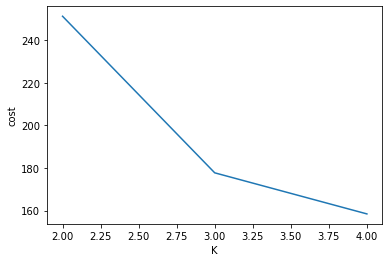

In [30]:
plt.plot(k, cost)
plt.xlabel('K')
plt.ylabel('cost')

In [31]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=6, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2,gamma=.75) 
clusters = kproto.fit_predict(X, categorical=list(range(7)))

In [32]:
X["Cluster_id"] = clusters

<ipython-input-32-07f1accaeac3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Cluster_id"] = clusters


In [33]:
import seaborn as sns

In [34]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [35]:
X_embedded = TSNE(n_components=2,metric = "cosine", random_state=0).fit_transform(X.iloc[:,:-1])

C:\Users\deban\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [36]:

X_embedded

array([[ 9.8850832e+00,  7.8428096e-01],
       [ 1.2980024e+01,  1.9779547e+00],
       [ 1.1304504e+01,  1.9362381e-01],
       [ 1.2281340e+01,  2.8274708e+00],
       [ 1.1466292e+01,  1.5761651e-01],
       [ 1.2332729e+01,  3.5418913e+00],
       [ 1.2127804e+01,  2.2969036e+00],
       [ 1.1701176e+01,  5.1535243e-01],
       [ 1.1649290e+01,  2.1006322e-01],
       [ 1.1483247e+01, -2.0340005e-02],
       [ 1.1497316e+01, -3.2635480e-03],
       [ 1.2456665e+01,  4.0397081e+00],
       [ 1.2266239e+01,  3.7277429e+00],
       [ 1.2465957e+01,  3.9716887e+00],
       [ 5.7960682e+00,  7.5184546e+00],
       [ 4.7236757e+00,  8.2621050e+00],
       [ 5.2728672e+00,  8.2662811e+00],
       [ 7.4312224e+00,  9.4736443e+00],
       [ 7.7047577e+00,  9.3046064e+00],
       [ 8.2017698e+00,  8.8290300e+00],
       [ 8.5174274e+00,  8.6211796e+00],
       [ 8.5587454e+00,  8.4366674e+00],
       [ 8.7047300e+00,  9.2707834e+00],
       [ 8.9561796e+00,  9.1094561e+00],
       [ 9.15586

In [37]:
X_embedded[:5,:]

array([[ 9.885083  ,  0.78428096],
       [12.980024  ,  1.9779547 ],
       [11.304504  ,  0.19362381],
       [12.28134   ,  2.8274708 ],
       [11.466292  ,  0.15761651]], dtype=float32)

In [38]:
X_embedded[:, 0]

array([ 9.885083 , 12.980024 , 11.304504 , 12.28134  , 11.466292 ,
       12.332729 , 12.127804 , 11.701176 , 11.64929  , 11.483247 ,
       11.497316 , 12.456665 , 12.266239 , 12.465957 ,  5.796068 ,
        4.7236757,  5.272867 ,  7.4312224,  7.7047577,  8.20177  ,
        8.517427 ,  8.558745 ,  8.70473  ,  8.95618  ,  9.155862 ,
        9.157351 ,  7.480223 ,  8.928748 ,  6.990918 ,  5.947131 ,
        4.482017 ,  6.2609444,  7.82031  ,  6.605372 ,  7.095106 ,
        6.6490593,  6.602765 ,  7.401599 ,  8.207935 ,  7.9458895,
        6.136821 ,  8.951526 ,  5.359501 ,  5.2432675,  4.7703056,
        5.6377664,  5.1542296,  5.548952 ,  7.9908504,  9.360032 ,
        9.660212 ,  8.430107 ,  6.153514 ,  6.2754035,  8.813545 ,
        4.201056 ,  4.719664 ,  9.799028 ,  3.9754286,  3.9768393,
        4.1823373,  4.341685 ,  4.1769867,  7.0690236,  5.790392 ,
        6.5889163,  6.12144  ,  5.6872067,  6.124524 ,  6.5410666,
        5.8661375,  6.69537  ,  6.263771 ,  6.7987213,  6.3659

In [39]:
a=X_embedded[:, 0]
b=a[:5]
b

array([ 9.885083, 12.980024, 11.304504, 12.28134 , 11.466292],
      dtype=float32)

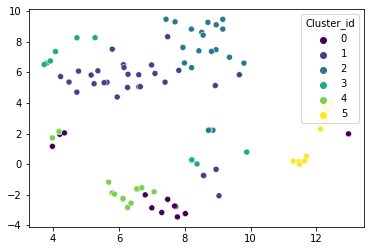

In [40]:
# Plotting the cluster centers 
#plt.style.use('fivethirtyeight')
sns.scatterplot(x= X_embedded[:, 0],y = X_embedded[:, -1], hue = X["Cluster_id"], palette= "viridis")
plt.show()

In [27]:
features["Cluster_id"] = clusters

# **Data Analysis**

<AxesSubplot:xlabel='Cluster_id', ylabel='payment_amount'>

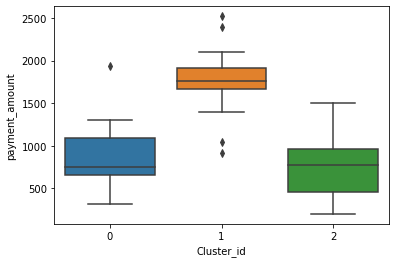

In [28]:
sns.boxplot(y = "payment_amount", data = features, x = "Cluster_id")

In [29]:
cols = ['sys',
 'g_int_typ',
 'g_bus_unit',
 'gen_skill',
 'last_session_flag',
 'recommending_user_code',
 'Legal_Name']

In [30]:
data["Cluster_id"] = clusters

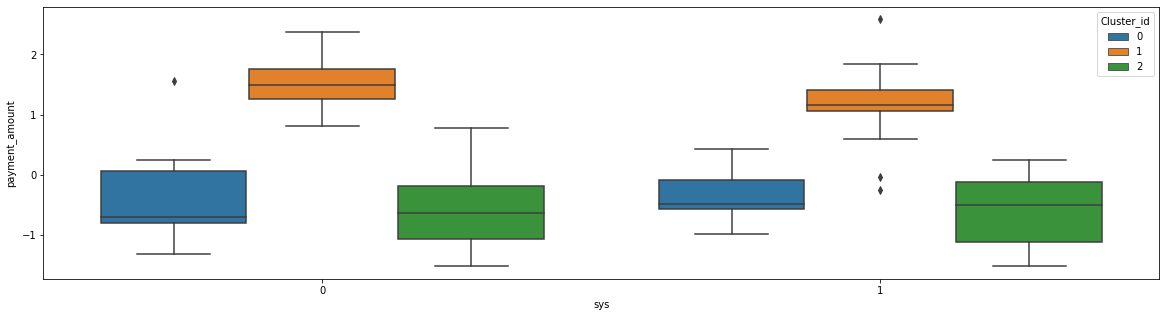

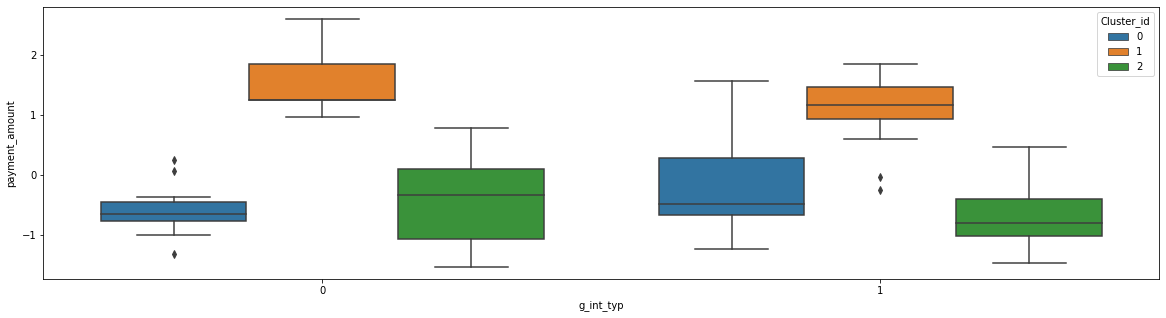

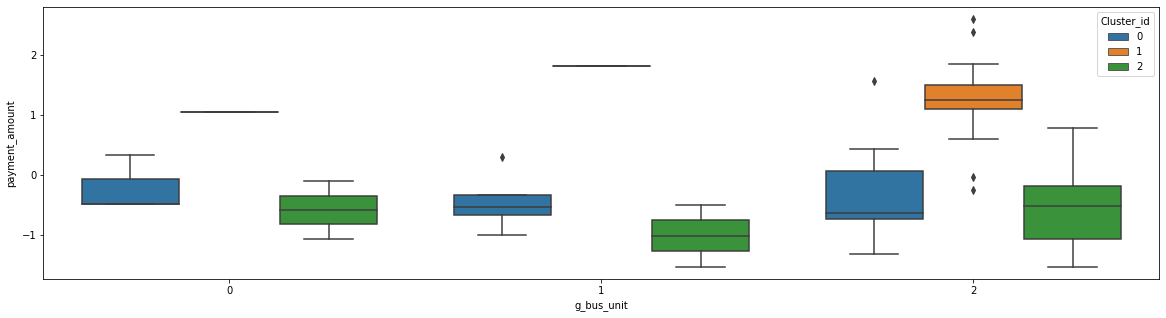

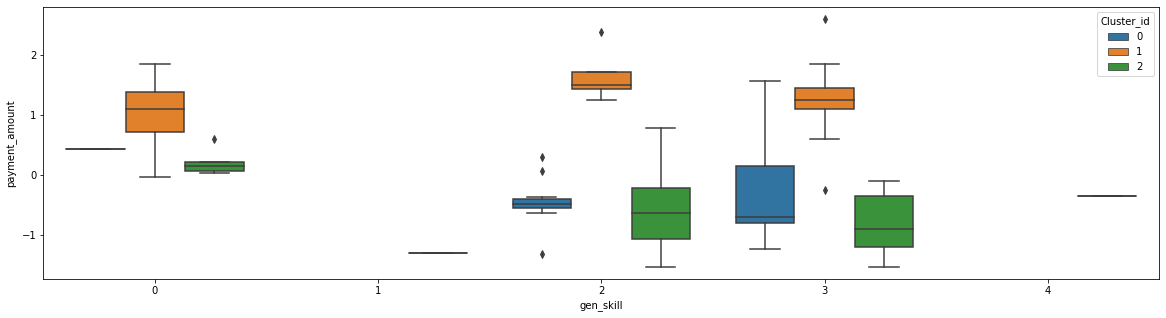

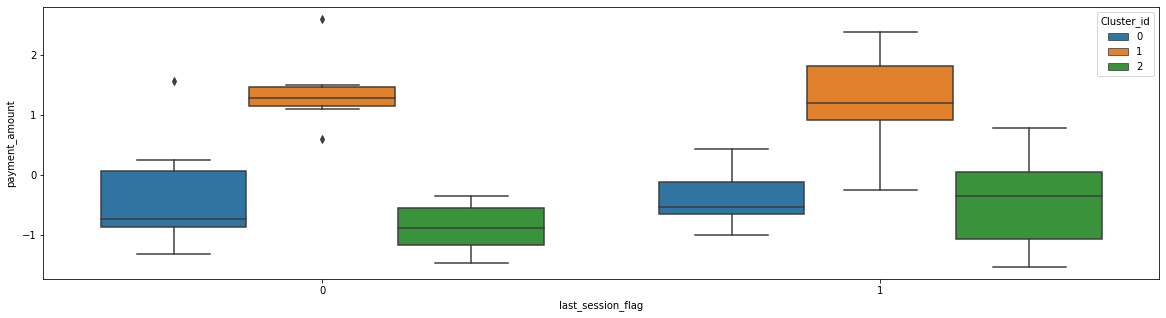

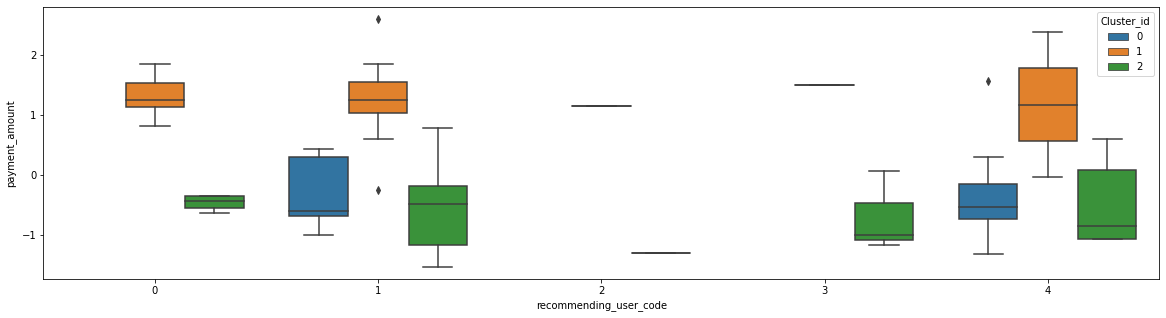

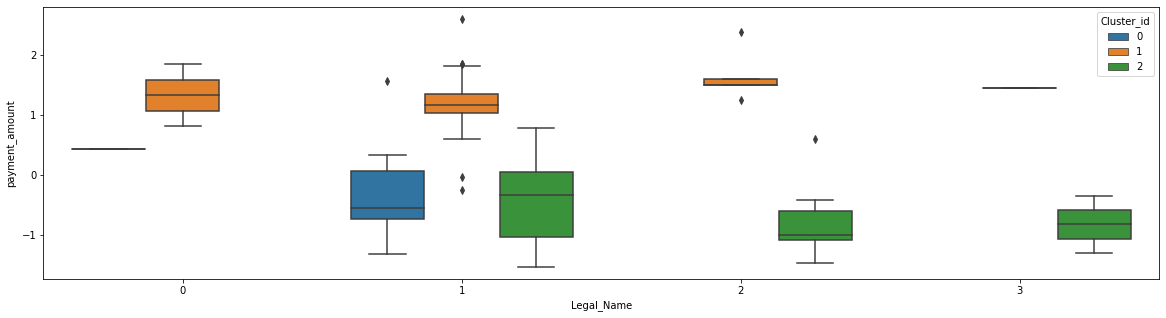

In [31]:
for col in cols:
    plt.figure(figsize=(20,5))
    sns.boxplot(y = "payment_amount",  hue = "Cluster_id" , x = col, data = data)

In [32]:
features

,sys,g_int_typ,g_bus_unit,gen_skill,lump_sum_typ_service_Code,payment_reason_type,payment_amount,recommending_user_code,Legal_Name,Cluster_id
0,Gen&Vet,inbound,WorkandIncome,WI_Gen_Advances,"Hotels, Motels, Resorts",70,330.0,HYAT,TWC,2
1,Gen&Vet,outbound,WorkandIncome,WI_Appointments,"Eating Places, Restaurants",856,1300.0,GEHU,BL,0
2,Gen,inbound,WorkandIncome,WI_Appointments,Quick Payment Service-Fast-Food Restaurants,93,1400.0,OKAT,TPD,2
3,Gen&Vet,outbound,WorkandIncome,WI_Appointments,Taxi Services,72,1400.0,GEHU,PKS,1
4,Gen,inbound,WorkandIncome,WI_Appointments,"Hotels, Motels, Resorts",65,1100.0,LKUY,PKS,2
...,...,...,...,...,...,...,...,...,...,...
94,Gen,outbound,WorkandIncome,WI_Repeat_Caller,"Package Stores, Beer, Wine, Liquor",90,230.0,GEHU,TPD,2
95,Gen,outbound,WorkandIncome,WI_Repeat_Caller,Travel Agencies and Tour Operators,90,630.0,GEHU,TPD,2
96,Gen,outbound,WorkandIncome,WI_Repeat_Caller,Travel Agencies and Tour Operators,90,500.0,LKUY,TPD,2
97,Gen,inbound,WorkandIncome,WI_Repeat_Caller,Taxi Services,90,1900.0,LKUY,TPD,1


In [33]:
group=features.groupby(features['Cluster_id'])
group

In [34]:
cluster0=group.get_group(0)
cluster0=cluster0.reset_index()
del cluster0['index']
cluster0.head()

,sys,g_int_typ,g_bus_unit,gen_skill,lump_sum_typ_service_Code,payment_reason_type,payment_amount,recommending_user_code,Legal_Name,Cluster_id
0,Gen&Vet,outbound,WorkandIncome,WI_Appointments,"Eating Places, Restaurants",856,1300.0,GEHU,BL,0
1,Gen&Vet,outbound,WorkandIncome,WI_Seniors,Air Canada,856,720.0,GEHU,PKS,0
2,Gen&Vet,inbound,StudyLink,WI_Seniors,Travel Agencies and Tour Operators,856,500.0,GEHU,PKS,0
3,Gen&Vet,outbound,Seniors,WI_Seniors,Quick Payment Service-Fast-Food Restaurants,856,1250.0,GEHU,PKS,0
4,Gen,inbound,WorkandIncome,WI_Seniors,Quick Payment Service-Fast-Food Restaurants,856,680.0,GEHU,PKS,0


In [35]:
#cluster0.to_excel("cluster0.xlsx")